In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station

measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_dates = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_dates

('2017-08-23',)

In [10]:
recent_date_dt = dt.datetime.strptime('2017-08-23','%Y-%m-%d')

# Calculate the date one year from the last date in data set.

year_ago_dt = recent_date_dt - dt.timedelta(days=365)
year_ago_dt = year_ago_dt.date().isoformat()
year_ago_dt

'2016-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [measurement.date, measurement.prcp]
query = session.query(*sel).\
filter(func.strftime('%Y-%m-%d',measurement.date) >='2016-08-23').\
filter(func.strftime('%Y-%m-%d',measurement.date) <='2017-08-23').all()


Text(0.5, 1.0, 'Precipitation over the Past 12 Months')

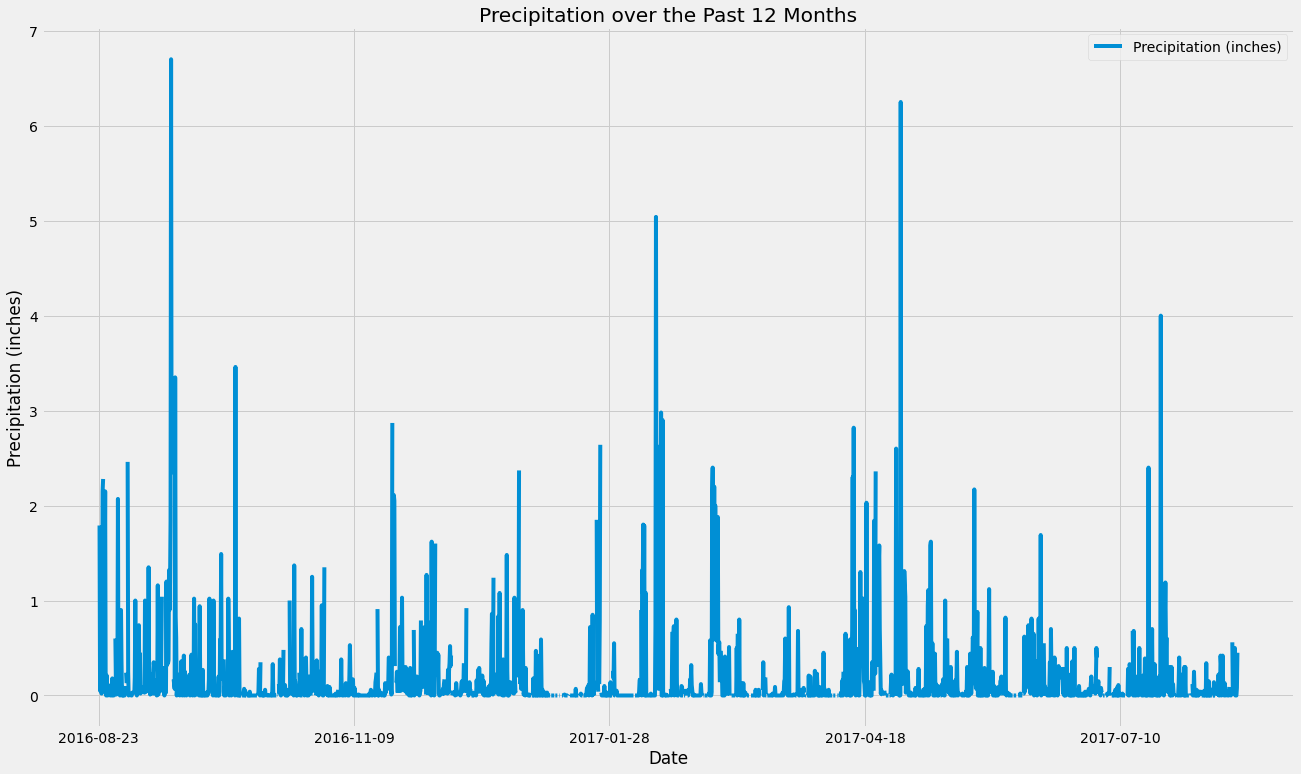

In [12]:
prcp_df = pd.DataFrame(query, columns=['Date','Precipitation (inches)'])
prcp_df = prcp_df.sort_values('Date')
prcp_df.set_index('Date',inplace=True)
prcp_df.plot(figsize=(20,12))
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation over the Past 12 Months')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station).count()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
display = [measurement.station, func.count(measurement.station)]
activity = session.query(*display).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(measurement.station, measurement.tobs).\
filter(measurement.station == 'USC00519281').order_by((measurement.tobs).desc()).first()

min_temp = session.query(measurement.station, measurement.tobs).\
filter(measurement.station == 'USC00519281').order_by((measurement.tobs).asc()).first()

avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

print(max_temp)
print(min_temp)
print(avg_temp)

('USC00519281', 85.0)
('USC00519281', 54.0)
[('USC00519281', 71.66378066378067)]


Text(0.5, 1.0, 'Temperatures Observed by Station USC00519281 in the Past Year')

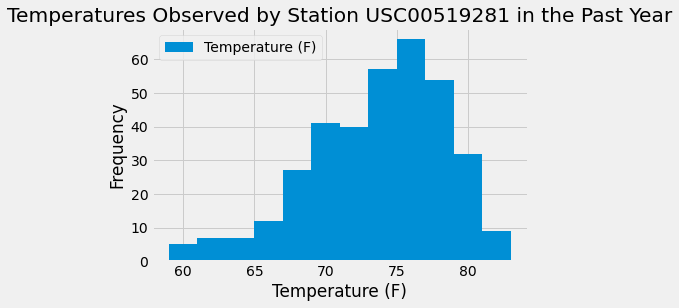

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#query to find most recent date
station_temps = [measurement.date, measurement.tobs]
query_temp_raw = session.query(*station_temps).\
filter(measurement.station =='USC00519281').order_by(measurement.date.desc()).all()

#query_temp_raw indicates that most recent date for this station is 2017-08-18. 
#Refine query to narrow down results to the past 12 months 
query_temp = session.query(*station_temps).\
filter(measurement.station =='USC00519281').\
filter(measurement.date >= '2016-08-18').\
order_by(measurement.date.desc()).all()

temp_df = pd.DataFrame(query_temp, columns=['Date', 'Temperature (F)'])
temp_df.plot.hist(bins=12)
plt.xlabel('Temperature (F)')
plt.title('Temperatures Observed by Station USC00519281 in the Past Year')

# Close session

In [18]:
# Close Session
session.close()